In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)


In [5]:
panel_df = pd.read_csv("calgary_traffic_panel_dataset.csv")
# or pd.read_csv(...)

panel_df.head()


,COMM_CODE,year_month,community_name,area_km2,total_incidents,severe_incidents,avg_severity,avg_mean_temp,total_snow_cm,total_precip_mm,...,cold_days_flag,month,sin_month,cos_month,lag_1,lag_3_avg,rolling_std_6,high_risk,top_25_flag,lag_severe
0,ABB,2016-12,ABBEYDALE,1.70414,0.0,0.0,0.0,-10.316667,26.1,22.4,...,0,12,-2.449294e-16,1.000000e+00,0.0,0.000000,0.0,0,0,NaN
1,ABB,2017-01,ABBEYDALE,1.70414,0.0,0.0,0.0,-6.766667,14.7,10.5,...,0,1,5.000000e-01,8.660254e-01,0.0,0.000000,0.0,0,0,0.0
2,ABB,2017-02,ABBEYDALE,1.70414,0.0,0.0,0.0,-7.081481,35.8,30.8,...,0,2,8.660254e-01,5.000000e-01,0.0,0.000000,0.0,0,0,0.0
3,ABB,2017-03,ABBEYDALE,1.70414,1.0,0.0,0.0,-2.412903,16.7,16.2,...,0,3,1.000000e+00,6.123234e-17,0.0,0.333333,0.0,0,0,0.0
4,ABB,2017-04,ABBEYDALE,1.70414,0.0,0.0,0.0,4.800000,16.6,67.3,...,0,4,8.660254e-01,-5.000000e-01,1.0,0.333333,0.0,0,0,0.0


# Baselines

In [6]:
panel_df = panel_df.sort_values(["COMM_CODE", "year_month"])

# Create next-month target
panel_df["high_risk_next_month"] = (
    panel_df
    .groupby("COMM_CODE")["high_risk"]
    .shift(-1)
)

# Drop rows where next month does not exist
panel_df = panel_df.dropna(subset=["high_risk_next_month"])

# Convert to integer
panel_df["high_risk_next_month"] = panel_df["high_risk_next_month"].astype(int)


In [7]:
# panel_df = panel_df.sort_values(["COMM_CODE", "year_month"])

train = panel_df[panel_df["year_month"] < "2023-01"]
test  = panel_df[panel_df["year_month"] >= "2023-01"]

drop_cols = ["COMM_CODE", "community_name", "year_month", "high_risk", "total_incidents", "severe_incidents", "incidents_per_1000",
    "severe_per_1000", "incidents_per_km2", "top_25_flag", "high_risk_next_month"]

X_train = train.drop(columns=drop_cols)
y_train = train["high_risk_next_month"]

X_test = test.drop(columns=drop_cols)
y_test = test["high_risk_next_month"]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (14454, 19)
Test size: (7326, 19)


### **Logistic Regression**

In [8]:
logreg_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight="balanced"
    ))
])

logreg_pipeline.fit(X_train, y_train)

y_pred = logreg_pipeline.predict(X_test)
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.87      0.66      0.75      5536
           1       0.40      0.69      0.50      1790

    accuracy                           0.67      7326
   macro avg       0.63      0.68      0.63      7326
weighted avg       0.75      0.67      0.69      7326

ROC-AUC: 0.7358321963703297


### **Random Forest (Nonlinear Model)**

In [9]:
rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


              precision    recall  f1-score   support

           0       0.85      0.79      0.82      5536
           1       0.47      0.57      0.51      1790

    accuracy                           0.74      7326
   macro avg       0.66      0.68      0.67      7326
weighted avg       0.76      0.74      0.75      7326

ROC-AUC: 0.7481485331158976


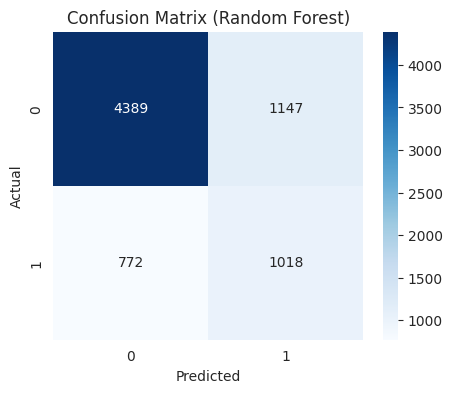

In [10]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Random Forest)")
plt.show()


# New Section

In [11]:
# ---------------------------------------------------------------
# Recreate target column (in case panel_df was reloaded from CSV)
# ---------------------------------------------------------------
panel_df = panel_df.sort_values(["COMM_CODE", "year_month"])

panel_df["high_risk_next_month"] = (
    panel_df
    .groupby("COMM_CODE")["high_risk"]
    .shift(-1)
)
panel_df = panel_df.dropna(subset=["high_risk_next_month"])
panel_df["high_risk_next_month"] = panel_df["high_risk_next_month"].astype(int)

# ---------------------------------------------------------------
# Winsorize rate columns to handle small-population distortion
# ---------------------------------------------------------------
for col in ['severe_per_1000', 'incidents_per_1000', 'incidents_per_km2']:
    cap = panel_df[col].quantile(0.99)
    panel_df[col] = panel_df[col].clip(upper=cap)

# ---------------------------------------------------------------
# Community historical mean risk (expanding mean — no future leakage)
# ---------------------------------------------------------------
panel_df["community_mean_risk"] = (
    panel_df.groupby("COMM_CODE")["high_risk"]
    .transform(lambda x: x.shift(1).expanding().mean())
)
global_mean = panel_df["high_risk"].mean()
panel_df["community_mean_risk"] = panel_df["community_mean_risk"].fillna(global_mean)

# ---------------------------------------------------------------
# Feature Selection
# ---------------------------------------------------------------
feature_cols = [
    'area_km2', 'population', 'population_density',
    'total_incidents', 'severe_incidents', 'avg_severity',
    'incidents_per_1000', 'severe_per_1000', 'incidents_per_km2',
    'avg_mean_temp', 'total_snow_cm', 'total_precip_mm',
    'snow_days', 'high_wind_days',
    'snow_squared', 'wind_snow_interaction', 'cold_days_flag',
    'month', 'sin_month', 'cos_month',
    'lag_1', 'lag_3_avg', 'rolling_std_6', 'lag_severe',
    'community_mean_risk',
]

X = panel_df[feature_cols].copy()
y = panel_df["high_risk_next_month"].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True).round(3)}")
print(f"\nFeatures used ({len(feature_cols)}):\n{feature_cols}")

Feature matrix shape: (21582, 25)
Target distribution:
high_risk_next_month
0    0.76
1    0.24
Name: proportion, dtype: float64

Features used (25):
['area_km2', 'population', 'population_density', 'total_incidents', 'severe_incidents', 'avg_severity', 'incidents_per_1000', 'severe_per_1000', 'incidents_per_km2', 'avg_mean_temp', 'total_snow_cm', 'total_precip_mm', 'snow_days', 'high_wind_days', 'snow_squared', 'wind_snow_interaction', 'cold_days_flag', 'month', 'sin_month', 'cos_month', 'lag_1', 'lag_3_avg', 'rolling_std_6', 'lag_severe', 'community_mean_risk']


In [12]:
panel_df.groupby("COMM_CODE")["community_mean_risk"].last().sort_values(ascending=False).head(10)


,community_mean_risk
COMM_CODE,
BRD,0.935185
DNC,0.925926
WIN,0.870370
MEA,0.824074
ALB,0.796296
VIS,0.777778
SOV,0.768519
MPL,0.759259
SNA,0.731481


In [13]:

# # Drop non-feature columns
# feature_cols = [
#     'area_km2', 'total_incidents', 'severe_incidents', 'avg_severity',
#     'avg_mean_temp', 'total_snow_cm', 'total_precip_mm', 'snow_days',
#     'high_wind_days', 'population', 'population_density', 'incidents_per_1000',
#     'severe_per_1000', 'incidents_per_km2', 'snow_squared', 'wind_snow_interaction',
#     'cold_days_flag', 'month', 'sin_month', 'cos_month', 'lag_1', 'lag_3_avg',
#     'rolling_std_6', 'top_25_flag', 'lag_severe'
# ]

# X = panel_df[feature_cols]
# y = panel_df['high_risk_next_month']

# # Sort by time for TimeSeriesSplit
# panel_df = panel_df.sort_values(["year_month", "COMM_CODE"]).reset_index(drop=True)
# X = X.loc[panel_df.index]
# y = y.loc[panel_df.index]

# # Optional: feature scaling (important for models like Logistic Regression)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


In [14]:
# ---------------------------------------------------------------
# TimeSeriesSplit CV — proper panel-aware implementation
# ---------------------------------------------------------------

# Get sorted unique months and split on those — not on row indices
time_periods = sorted(panel_df["year_month"].unique())
n_splits = 5

# Build fold boundaries: each fold adds one chunk of months to training
# and validates on the next chunk
n = len(time_periods)
fold_size = n // (n_splits + 1)

folds = []
for i in range(1, n_splits + 1):
    train_end = time_periods[fold_size * i - 1]
    val_start = time_periods[fold_size * i]
    val_end   = time_periods[min(fold_size * (i + 1) - 1, n - 1)]
    folds.append((train_end, val_start, val_end))

# Class imbalance ratio for XGBoost
neg = (y == 0).sum()
pos = (y == 1).sum()
scale_pos = round(neg / pos, 2)
print(f"scale_pos_weight for XGBoost: {scale_pos}\n")

rf_aucs  = []
xgb_aucs = []

for fold_num, (train_end, val_start, val_end) in enumerate(folds):

    train_mask = panel_df["year_month"] <= train_end
    val_mask   = (panel_df["year_month"] >= val_start) & (panel_df["year_month"] <= val_end)

    X_tr_raw, X_val_raw = X[train_mask], X[val_mask]
    y_tr,     y_val     = y[train_mask], y[val_mask]

    # Fit scaler on train fold only — no future leakage
    scaler = StandardScaler()
    X_tr  = scaler.fit_transform(X_tr_raw)
    X_val_scaled = scaler.transform(X_val_raw)

    train_months = panel_df[train_mask]["year_month"]
    val_months   = panel_df[val_mask]["year_month"]
    print(f"Fold {fold_num+1}: train up to {train_months.max()} | "
          f"val {val_months.min()} → {val_months.max()} | "
          f"train size: {len(y_tr)}, val size: {len(y_val)}")

    # Random Forest
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_tr, y_tr)
    rf_probs = rf.predict_proba(X_val_scaled)[:, 1]
    rf_auc = roc_auc_score(y_val, rf_probs)
    rf_aucs.append(rf_auc)

    # XGBoost
    xgb = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos,   # handles class imbalance
        random_state=42,
        eval_metric="logloss",
        verbosity=0
    )
    xgb.fit(X_tr, y_tr)
    xgb_probs = xgb.predict_proba(X_val_scaled)[:, 1]
    xgb_auc = roc_auc_score(y_val, xgb_probs)
    xgb_aucs.append(xgb_auc)

print(f"\nRandom Forest  — CV AUCs: {[round(a,4) for a in rf_aucs]}  | Mean: {np.mean(rf_aucs):.4f}")
print(f"XGBoost        — CV AUCs: {[round(a,4) for a in xgb_aucs]} | Mean: {np.mean(xgb_aucs):.4f}")
print(f"\nBest model: {'Random Forest' if np.mean(rf_aucs) > np.mean(xgb_aucs) else 'XGBoost'}")

scale_pos_weight for XGBoost: 3.17

Fold 1: train up to 2018-05 | val 2018-06 → 2019-11 | train size: 3564, val size: 3564
Fold 2: train up to 2019-11 | val 2019-12 → 2021-05 | train size: 7128, val size: 3564
Fold 3: train up to 2021-05 | val 2021-06 → 2022-11 | train size: 10692, val size: 3564
Fold 4: train up to 2022-11 | val 2022-12 → 2024-05 | train size: 14256, val size: 3564
Fold 5: train up to 2024-05 | val 2024-06 → 2025-11 | train size: 17820, val size: 3564

Random Forest  — CV AUCs: [np.float64(0.7925), np.float64(0.6922), np.float64(0.7987), np.float64(0.7893), np.float64(0.7623)]  | Mean: 0.7670
XGBoost        — CV AUCs: [np.float64(0.7699), np.float64(0.676), np.float64(0.7514), np.float64(0.7554), np.float64(0.7194)] | Mean: 0.7344

Best model: Random Forest


### **TimeSeriesSplit Cross-Validation**

Using: Random Forest

Test ROC-AUC: 0.7739
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      5387
           1       0.50      0.60      0.55      1741

    accuracy                           0.76      7128
   macro avg       0.68      0.70      0.69      7128
weighted avg       0.77      0.76      0.76      7128



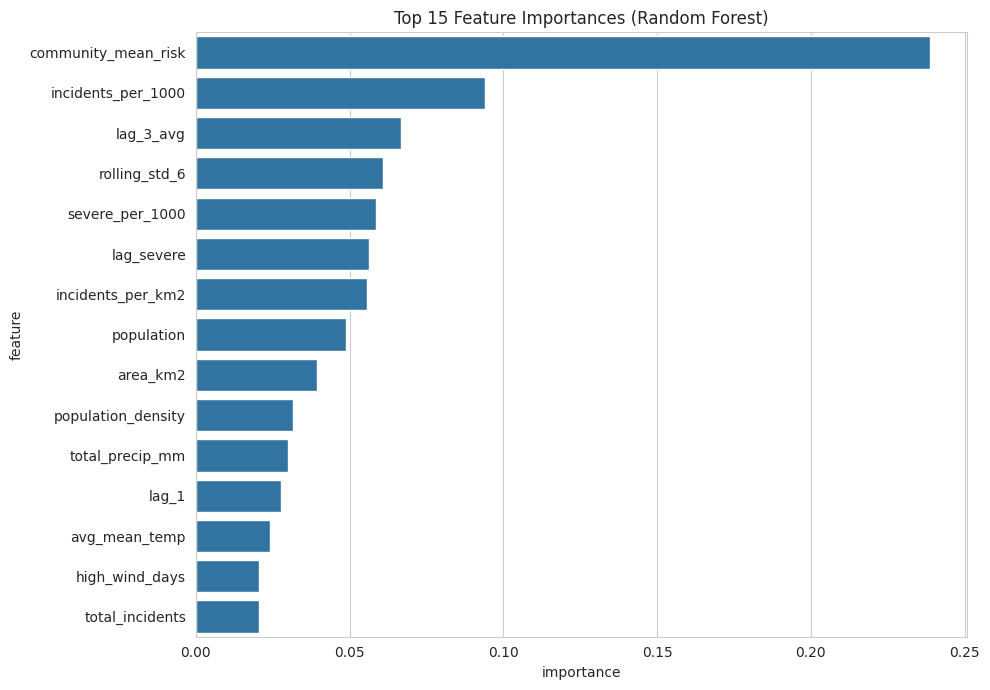


Top 10 features:


,feature,importance
24,community_mean_risk,0.238771
6,incidents_per_1000,0.094144
21,lag_3_avg,0.066662
22,rolling_std_6,0.060907
7,severe_per_1000,0.058558
23,lag_severe,0.056246
8,incidents_per_km2,0.055657
1,population,0.048918
0,area_km2,0.039288
2,population_density,0.031557


In [15]:
# ---------------------------------------------------------------
# Final Model — train on train set only, evaluate on held-out test
# ---------------------------------------------------------------

train_mask = panel_df["year_month"] < "2023-01"
test_mask  = panel_df["year_month"] >= "2023-01"

X_train_raw, X_test_raw = X[train_mask], X[test_mask]
y_train,     y_test     = y[train_mask], y[test_mask]

# Fit scaler on train only
final_scaler = StandardScaler()
X_train_scaled = final_scaler.fit_transform(X_train_raw)
X_test_scaled  = final_scaler.transform(X_test_raw)

# Use actual column names from X (avoids mismatch with feature_cols list)
actual_feature_cols = list(X.columns)

# Wrap in DataFrame to preserve column names for both models
X_train_df = pd.DataFrame(X_train_scaled, columns=actual_feature_cols)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=actual_feature_cols)

# Pick winner from CV
best_model_name = "Random Forest" if np.mean(rf_aucs) > np.mean(xgb_aucs) else "XGBoost"
print(f"Using: {best_model_name}")

if best_model_name == "Random Forest":
    final_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
else:
    final_model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos,
        random_state=42,
        eval_metric="logloss",
        verbosity=0
    )

final_model.fit(X_train_df, y_train)
y_pred  = final_model.predict(X_test_df)
y_proba = final_model.predict_proba(X_test_df)[:, 1]

print(f"\nTest ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(classification_report(y_test, y_pred))

# Feature importance — gain for XGBoost, default for RF
if best_model_name == "XGBoost":
    importances = final_model.get_booster().get_score(importance_type="gain")
    importance_df = pd.DataFrame(
        importances.items(), columns=["feature", "importance"]
    ).sort_values("importance", ascending=False)
else:
    importance_df = pd.DataFrame({
        "feature": actual_feature_cols,
        "importance": final_model.feature_importances_
    }).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x="importance", y="feature", data=importance_df.head(15))
plt.title(f"Top 15 Feature Importances ({best_model_name})")
plt.tight_layout()
plt.show()

print("\nTop 10 features:")
display(importance_df.head(10))

In [19]:
# Reload raw data just for the forecast row — 2026-02 was dropped from panel_df
# during target construction (no next month exists for it, correct for training)
forecast_base = pd.read_csv("calgary_traffic_panel_dataset.csv")

# Re-apply winsorization using caps learned from panel_df
for col in ['severe_per_1000', 'incidents_per_1000', 'incidents_per_km2']:
    cap = panel_df[col].max()  # panel_df was already winsorized at 99th pct
    forecast_base[col] = forecast_base[col].clip(upper=cap)

# Re-attach community_mean_risk from panel_df (expanding mean up to last available month)
comm_mean = (
    panel_df.groupby("COMM_CODE")["community_mean_risk"].last()
)
forecast_base["community_mean_risk"] = forecast_base["COMM_CODE"].map(comm_mean)

Forecasting high-risk communities for: 2026-03
Communities found for 2026-02: 198

Historical climate averages for month 3:
avg_mean_temp      -2.26
total_snow_cm      24.64
total_precip_mm    21.73
snow_days           9.11
high_wind_days      6.56
dtype: float64

High-Risk Predictions: 7 of 198 communities flagged


,COMM_CODE,community_name,year_month,high_risk_pred,high_risk_prob
0,SNA,SUNALTA,2026-03,1,0.5925
1,ALB,ALBERT PARK/RADISSON HEIGHTS,2026-03,1,0.5323
2,KIN,KINGSLAND,2026-03,1,0.5251
3,WIN,WINSTON HEIGHTS/MOUNTVIEW,2026-03,1,0.5174
4,DNC,DOWNTOWN COMMERCIAL CORE,2026-03,1,0.5109
5,REN,RENFREW,2026-03,1,0.5104
6,WHL,WEST HILLHURST,2026-03,1,0.5079
7,UOC,UNIVERSITY OF CALGARY,2026-03,0,0.4921
8,ING,INGLEWOOD,2026-03,0,0.4886
9,DNE,DOWNTOWN EAST VILLAGE,2026-03,0,0.4875


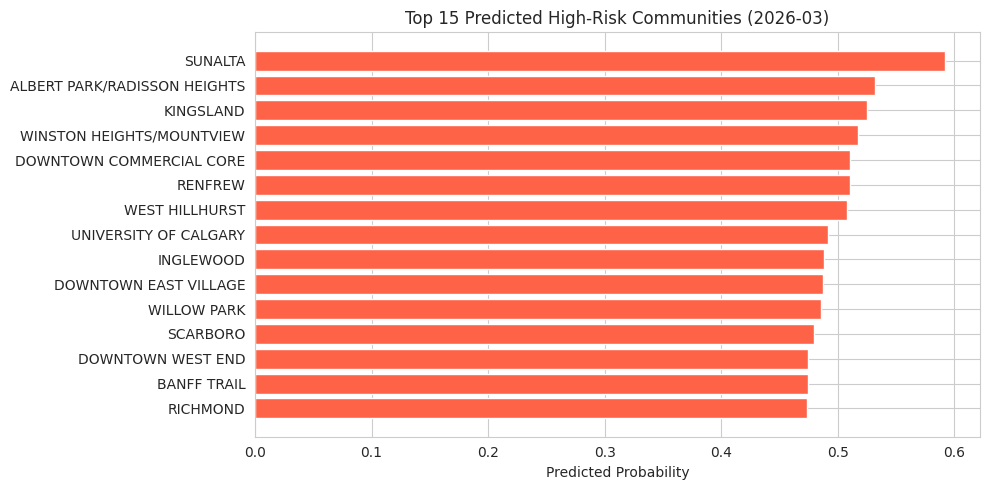

In [20]:
# ---------------------------------------------------------------
# Forecast: Predict High-Risk Communities for Next Month
# ---------------------------------------------------------------

last_month_str = "2026-02"
next_month_str = (pd.to_datetime(last_month_str) + pd.DateOffset(months=1)).strftime("%Y-%m")
next_month_num = pd.to_datetime(next_month_str).month

print(f"Forecasting high-risk communities for: {next_month_str}")

# ---------------------------------------------------------------
# Step 1: Get last month's data from the already-engineered panel_df
# (do NOT reload from CSV — we'd lose community_mean_risk, winsorized cols etc.)
# ---------------------------------------------------------------
last_month = forecast_base[forecast_base["year_month"] == last_month_str].copy()

if last_month.empty:
    raise ValueError(f"No data found for {last_month_str}. Check your panel_df.")

print(f"Communities found for {last_month_str}: {len(last_month)}")

# ---------------------------------------------------------------
# Step 2: Replace weather features with historical climate averages
# for the forecast month (March in Calgary) — we don't know future weather
# Historical averages computed from all past years in panel_df
# ---------------------------------------------------------------
historical_weather = (
    panel_df[panel_df["year_month"].str[5:7] == f"{next_month_num:02d}"]
    [[  "avg_mean_temp", "total_snow_cm", "total_precip_mm",
        "snow_days", "high_wind_days"]]
    .mean()
)

print(f"\nHistorical climate averages for month {next_month_num}:")
print(historical_weather.round(2))

# Apply historical averages to forecast row
X_next = last_month.copy()
X_next["year_month"]    = next_month_str
X_next["avg_mean_temp"] = historical_weather["avg_mean_temp"]
X_next["total_snow_cm"] = historical_weather["total_snow_cm"]
X_next["total_precip_mm"] = historical_weather["total_precip_mm"]
X_next["snow_days"]     = historical_weather["snow_days"]
X_next["high_wind_days"] = historical_weather["high_wind_days"]

# Recompute weather interaction features with updated values
X_next["snow_squared"]         = X_next["total_snow_cm"] ** 2
X_next["wind_snow_interaction"] = X_next["high_wind_days"] * X_next["total_snow_cm"]
X_next["cold_days_flag"]       = (X_next["avg_mean_temp"] < -10).astype(int)

# ---------------------------------------------------------------
# Step 3: Update temporal features for next month
# ---------------------------------------------------------------
X_next["month"]     = next_month_num
X_next["sin_month"] = np.sin(2 * np.pi * next_month_num / 12)
X_next["cos_month"] = np.cos(2 * np.pi * next_month_num / 12)

# ---------------------------------------------------------------
# Step 4: Update lag features
# current month (Feb) becomes lag_1 for the March forecast
# lag_3_avg and rolling_std_6 shift forward by one month
# ---------------------------------------------------------------
X_next["lag_1"]         = last_month["high_risk"].values
X_next["lag_severe"]    = last_month["severe_incidents"].values

# For lag_3_avg: average of last 3 months ending in Feb
lag3 = (
    panel_df[panel_df["year_month"] <= last_month_str]
    .groupby("COMM_CODE")
    .tail(3)
    .groupby("COMM_CODE")["high_risk"]
    .mean()
)
X_next["lag_3_avg"] = X_next["COMM_CODE"].map(lag3)

# For rolling_std_6: std of last 6 months ending in Feb
roll6 = (
    panel_df[panel_df["year_month"] <= last_month_str]
    .groupby("COMM_CODE")
    .tail(6)
    .groupby("COMM_CODE")["high_risk"]
    .std()
    .fillna(0)
)
X_next["rolling_std_6"] = X_next["COMM_CODE"].map(roll6)

# community_mean_risk: expanding mean up to and including Feb
X_next["community_mean_risk"] = X_next["COMM_CODE"].map(
    panel_df[panel_df["year_month"] <= last_month_str]
    .groupby("COMM_CODE")["high_risk"]
    .mean()
)

# ---------------------------------------------------------------
# Step 5: Scale and predict
# ---------------------------------------------------------------
X_next_features = X_next[actual_feature_cols]

X_next_scaled = final_scaler.transform(X_next_features)
X_next_df     = pd.DataFrame(X_next_scaled, columns=actual_feature_cols)

pred_probs   = final_model.predict_proba(X_next_df)[:, 1]
pred_classes = (pred_probs >= 0.5).astype(int)

# ---------------------------------------------------------------
# Step 6: Output
# ---------------------------------------------------------------
pred_df = pd.DataFrame({
    "COMM_CODE":       last_month["COMM_CODE"].values,
    "community_name":  last_month["community_name"].values,
    "year_month":      next_month_str,
    "high_risk_pred":  pred_classes,
    "high_risk_prob":  pred_probs.round(4)
}).sort_values("high_risk_prob", ascending=False).reset_index(drop=True)

print(f"\nHigh-Risk Predictions: {pred_classes.sum()} of {len(pred_classes)} communities flagged")
display(pred_df.head(15))

# Bar chart — top 15
plt.figure(figsize=(10, 5))
plt.barh(pred_df.head(15)["community_name"], pred_df.head(15)["high_risk_prob"], color="tomato")
plt.xlabel("Predicted Probability")
plt.title(f"Top 15 Predicted High-Risk Communities ({next_month_str})")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# New Section

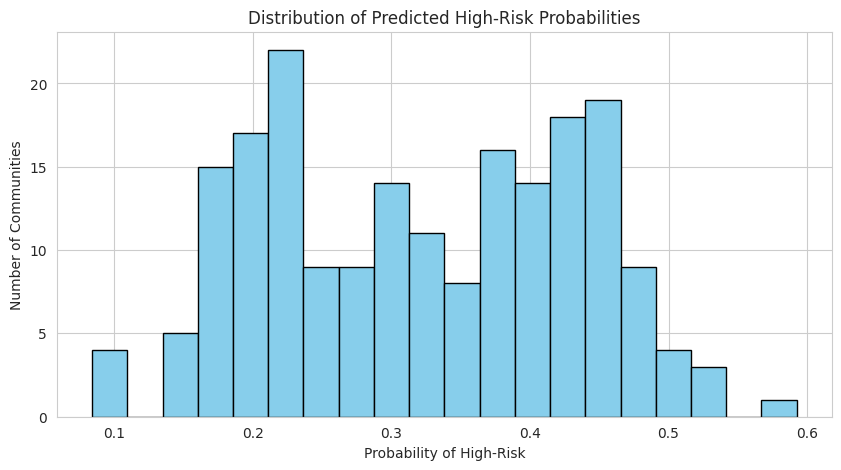

High-Risk Prediction Counts:


,count
high_risk_pred,
0,191
1,7


In [21]:
# Check distribution of predicted probabilities
plt.figure(figsize=(10,5))
plt.hist(pred_df["high_risk_prob"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Predicted High-Risk Probabilities")
plt.xlabel("Probability of High-Risk")
plt.ylabel("Number of Communities")
plt.show()

# Count of high-risk vs low-risk
print("High-Risk Prediction Counts:")
display(pred_df["high_risk_pred"].value_counts())


Top 10 High-Risk Communities for Next Month:


,COMM_CODE,community_name,year_month,high_risk_pred,high_risk_prob
0,SNA,SUNALTA,2026-03,1,0.5925
1,ALB,ALBERT PARK/RADISSON HEIGHTS,2026-03,1,0.5323
2,KIN,KINGSLAND,2026-03,1,0.5251
3,WIN,WINSTON HEIGHTS/MOUNTVIEW,2026-03,1,0.5174
4,DNC,DOWNTOWN COMMERCIAL CORE,2026-03,1,0.5109
5,REN,RENFREW,2026-03,1,0.5104
6,WHL,WEST HILLHURST,2026-03,1,0.5079
7,UOC,UNIVERSITY OF CALGARY,2026-03,0,0.4921
8,ING,INGLEWOOD,2026-03,0,0.4886
9,DNE,DOWNTOWN EAST VILLAGE,2026-03,0,0.4875


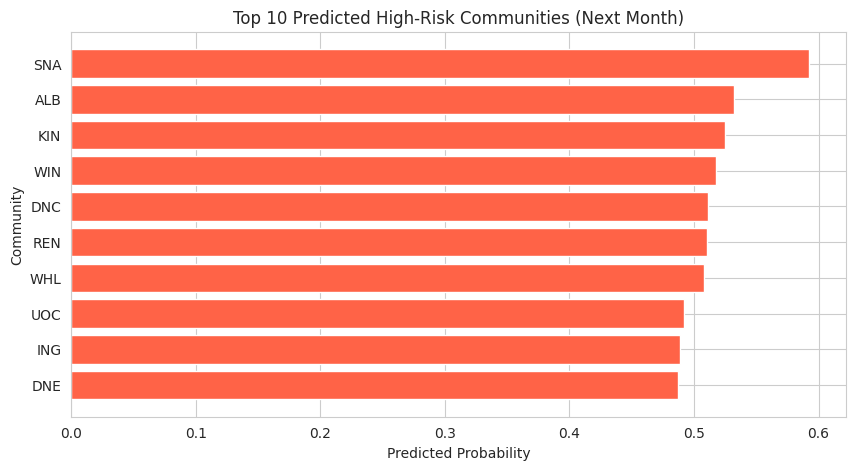

In [22]:
# Get top 10 communities by probability
top_10 = pred_df.sort_values("high_risk_prob", ascending=False).head(10)
print("Top 10 High-Risk Communities for Next Month:")
display(top_10)

# Optional: bar chart
plt.figure(figsize=(10,5))
plt.barh(top_10["COMM_CODE"], top_10["high_risk_prob"], color="tomato")
plt.xlabel("Predicted Probability")
plt.ylabel("Community")
plt.title("Top 10 Predicted High-Risk Communities (Next Month)")
plt.gca().invert_yaxis()
plt.show()
